In [1]:
import os
from pathlib import Path
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append('./SuperGluePretrainedNetwork')
from models.matching import Matching
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(42)
random.seed(42)

with torch.no_grad():
    matching = Matching({
        'superpoint': {'nms_radius': 4, 'keypoint_threshold': 0.005, 'max_keypoints': 1024},
        'superglue': {'weights': 'indoor'},
        'sinkhorn_iterations': 20,
        'match_threshold': 0.2,
    }).eval().to(device)



DICT_TYPE = cv2.aruco.DICT_5X5_100

aruco_dict = cv2.aruco.getPredefinedDictionary(DICT_TYPE)
detector = cv2.aruco.ArucoDetector(aruco_dict)

board = cv2.aruco.CharucoBoard((13, 9), 0.02, 0.01, aruco_dict)
world_corners_3d = board.getChessboardCorners()


/home/lbw/workspace/3D_CV_ICPBL/./SuperGluePretrainedNetwork/models/superpoint.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(str(path

Loaded SuperPoint model


/home/lbw/workspace/3D_CV_ICPBL/./SuperGluePretrainedNetwork/models/superglue.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(str(path)

Loaded SuperGlue model ("indoor" weights)


### Feature matching between 2 images

In [2]:
def feature_match_between_images(img1, img2):
    """Feature matching using SUPERGLUE."""
    
    # 텐서로 변환 (SUPERGLUE 입력 형식)
    img1 = cv2.resize(img1, (1024, 1024))
    img2 = cv2.resize(img2, (1024, 1024))
    tensor1 = torch.from_numpy(img1 / 255.).float()[None, None].to(device)
    tensor2 = torch.from_numpy(img2 / 255.).float()[None, None].to(device)


    # SUPERGLUE 매칭 수행
    inp = {'image0': tensor1, 'image1': tensor2}
    pred = matching(inp)
    
    # 결과 추출
    kpts0 = pred['keypoints0'][0].cpu().numpy()  # 이미지1의 키포인트
    kpts1 = pred['keypoints1'][0].cpu().numpy()  # 이미지2의 키포인트
    matches = pred['matches0'][0].cpu().numpy()  # 매칭 결과
    
    # 유효한 매칭만 필터링
    valid = matches > -1
    matched_kpts0 = kpts0[valid]
    matched_kpts1 = kpts1[matches[valid]]

    # ChArUco 형식과 동일한 반환값 구성
    good_matches = []
    matched_ids = []  # SUPERGLUE에서는 ID 개념이 없으므로 매칭 인덱스 사용
    
    for i, (pt0, pt1) in enumerate(zip(matched_kpts0, matched_kpts1)):
        # 튜플 형태로 변환 (ChArUco 형식과 동일)
        pt1_tuple = tuple(pt0.astype(float))
        pt2_tuple = tuple(pt1.astype(float))
        good_matches.append((pt1_tuple, pt2_tuple))
        
        # 매칭 인덱스를 ID로 사용 (신뢰도 기반 가중치 적용 가능)
        matched_ids.append(i)
    
    # 각 이미지에서 검출된 키포인트 수
    num_corners1 = len(kpts0)
    num_corners2 = len(kpts1)
    
    return good_matches, matched_ids, (num_corners1, num_corners2)

In [3]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def draw_superglue_matches(img1, img2, show_all_keypoints=True):
    """
    SUPERGLUE 매칭 결과 시각화
    
    Args:
        img1: 첫 번째 이미지
        img2: 두 번째 이미지
        show_all_keypoints: 모든 키포인트 표시 여부
    """
    
    # 이미지 리사이즈 및 전처리
    img1_resized = cv2.resize(img1, (1024, 1024))
    img2_resized = cv2.resize(img2, (1024, 1024))
    
    # 그레이스케일 변환
    if len(img1_resized.shape) == 3:
        img1_gray = cv2.cvtColor(img1_resized, cv2.COLOR_BGR2GRAY)
    else:
        img1_gray = img1_resized.copy()
        
    if len(img2_resized.shape) == 3:
        img2_gray = cv2.cvtColor(img2_resized, cv2.COLOR_BGR2GRAY)
    else:
        img2_gray = img2_resized.copy()
    
    # 텐서로 변환
    tensor1 = torch.from_numpy(img1_gray / 255.).float()[None, None].to(device)
    tensor2 = torch.from_numpy(img2_gray / 255.).float()[None, None].to(device)
    
    # SUPERGLUE 매칭 수행
    inp = {'image0': tensor1, 'image1': tensor2}
    pred = matching(inp)
    
    # 결과 추출
    kpts0 = pred['keypoints0'][0].cpu().numpy()    # 이미지1의 모든 키포인트
    kpts1 = pred['keypoints1'][0].cpu().numpy()    # 이미지2의 모든 키포인트
    matches = pred['matches0'][0].cpu().numpy()    # 매칭 결과
    
    # 유효한 매칭만 필터링
    valid = (matches > -1)
    matched_kpts0 = kpts0[valid]
    matched_kpts1 = kpts1[matches[valid]]
    
    # 매칭된 포인트 쌍 생성
    good_matches = []
    for i, (pt0, pt1) in enumerate(zip(matched_kpts0, matched_kpts1)):
        good_matches.append((tuple(pt0.astype(float)), tuple(pt1.astype(float))))
    
    # 캔버스 생성
    h1, w1 = img1_gray.shape
    h2, w2 = img2_gray.shape
    canvas = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
    canvas[:h1, :w1] = img1_gray
    canvas[:h2, w1:] = img2_gray
    
    # 컬러 이미지로 변환
    canvas_color = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
    
    # 모든 키포인트 그리기 (옵션)
    if show_all_keypoints:
        # 첫 번째 이미지의 모든 키포인트 (연한 파란색)
        for kpt in kpts0:
            cv2.circle(canvas_color, (int(kpt[0]), int(kpt[1])), 2, (255, 200, 100), -1)
        
        # 두 번째 이미지의 모든 키포인트 (연한 초록색)
        for kpt in kpts1:
            cv2.circle(canvas_color, (int(kpt[0] + w1), int(kpt[1])), 2, (100, 255, 200), -1)
    
    # 매칭된 키포인트 강조 표시
    for i, ((x1, y1), (x2, y2)) in enumerate(good_matches):
        # 고정 색상 사용
        color = (0, 255, 0)  # 초록색
        
        # 키포인트 그리기 (더 큰 원)
        cv2.circle(canvas_color, (int(x1), int(y1)), 4, color, -1)
        cv2.circle(canvas_color, (int(x2 + w1), int(y2)), 4, color, -1)
        
        # 키포인트 테두리
        cv2.circle(canvas_color, (int(x1), int(y1)), 5, (0, 0, 0), 1)
        cv2.circle(canvas_color, (int(x2 + w1), int(y2)), 5, (0, 0, 0), 1)
    
    # Matplotlib으로 시각화
    plt.figure(figsize=(16, 10))
    plt.imshow(cv2.cvtColor(canvas_color, cv2.COLOR_BGR2RGB))
    
    # 매칭선 그리기
    if len(good_matches) > 0:
        # 색상 맵 생성 (인덱스 기반)
        colors = plt.cm.viridis(np.linspace(0, 1, len(good_matches)))
        
        for i, ((x1, y1), (x2, y2)) in enumerate(good_matches):
            # 매칭선 그리기
            plt.plot([x1, x2 + w1], [y1, y2], 
                    color=colors[i], linewidth=1.5, alpha=0.7)
            
            # 매칭 인덱스 표시 (일부만)
            if i % 10 == 0:  # 10개마다 하나씩만 표시
                mid_x = (x1 + x2 + w1) / 2
                mid_y = (y1 + y2) / 2
                plt.text(mid_x, mid_y, str(i), 
                        fontsize=8, ha='center', va='center',
                        bbox=dict(boxstyle="round,pad=0.2", 
                                facecolor='white', alpha=0.8, edgecolor='none'))
    
    # 통계 정보 표시
    total_kpts1 = len(kpts0)
    total_kpts2 = len(kpts1)
    total_matches = len(good_matches)
    
    # 제목과 정보
    title = f"SUPERGLUE Matches\n"
    title += f"Keypoints: {total_kpts1} vs {total_kpts2} | "
    title += f"Matches: {total_matches}"
    
    plt.title(title, fontsize=14, pad=20)
    plt.axis('off')
    
    # 이미지 경계선 표시
    plt.axvline(x=w1, color='white', linestyle='--', alpha=0.8, linewidth=2)
    
    plt.tight_layout()
    plt.show()
    
    # 매칭 통계 출력
    print("=" * 50)
    print("SUPERGLUE 매칭 결과")
    print("=" * 50)
    print(f"이미지1 키포인트 수: {total_kpts1}")
    print(f"이미지2 키포인트 수: {total_kpts2}")
    print(f"총 매칭 수: {total_matches}")
    print(f"매칭 비율: {total_matches/min(total_kpts1, total_kpts2)*100:.1f}%")
    
    return good_matches


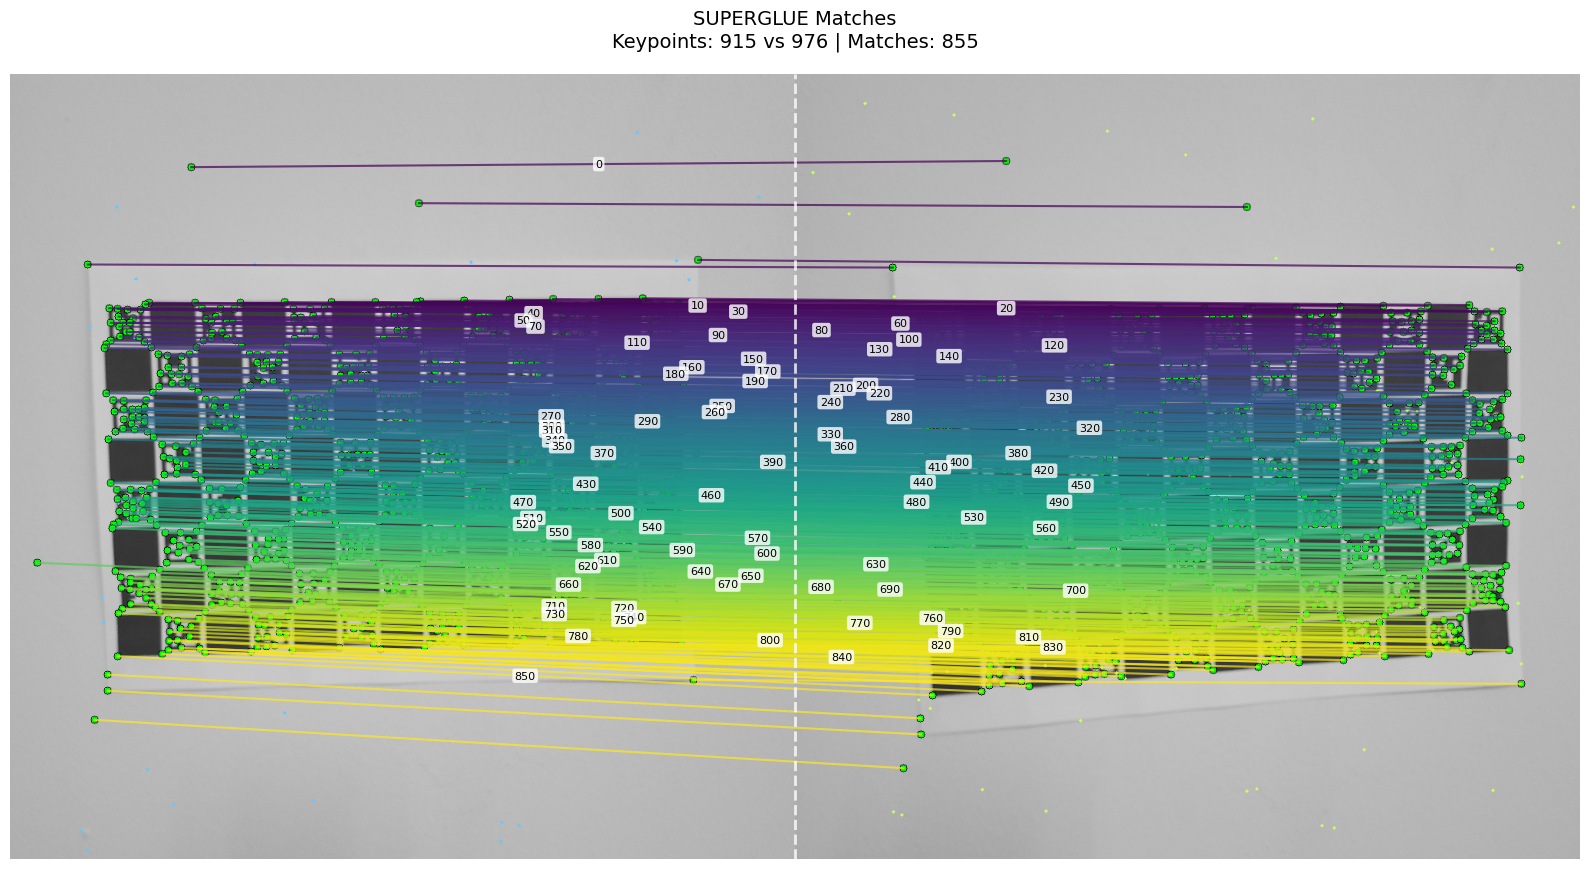

SUPERGLUE 매칭 결과
이미지1 키포인트 수: 915
이미지2 키포인트 수: 976
총 매칭 수: 855
매칭 비율: 93.4%
===ChArUco detect and match result===
image1: 915 corners, image2: 976 corners. 855 matches


In [4]:
IMAGE_DIR = Path('./camera_images3')

img1 = cv2.imread(str(IMAGE_DIR / '0.jpeg'), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(str(IMAGE_DIR / '1.jpeg'), cv2.IMREAD_GRAYSCALE)

matches, matched_ids, num_corners = feature_match_between_images(img1, img2)


draw_superglue_matches(img1, img2, show_all_keypoints=True)


print("===ChArUco detect and match result===")
print(f"image1: {num_corners[0]} corners, image2: {num_corners[1]} corners. {len(matches)} matches")

In [5]:
import cv2
import torch
import numpy as np

def feature_match_with_charucoboard(img, reference_img_path="./camera_images3/0.jpeg"):
    """
    실제 촬영된 이미지를 참조로 하는 ChArUco 매칭
    
    Args:
        img: 입력 이미지
        reference_img_path: ChArUco가 잘 보이는 참조 이미지 경로
    
    Returns:
        good_matches: [((world_x, world_y), (img_u, img_v)), ...]
        matched_ids: 매칭 인덱스
        num_corners: 매칭된 코너 수
    """
    
    # 참조 이미지 로드 및 전처리
    ref_img = cv2.imread(reference_img_path, cv2.IMREAD_GRAYSCALE)
    ref_img = cv2.resize(ref_img, (1024, 1024))
    
    # 참조 이미지에서 ChArUco 코너 검출
    corners_ref, ids_ref, _ = cv2.aruco.detectMarkers(ref_img, aruco_dict)
    if ids_ref is None:
        print("❌ 참조 이미지에서 ArUco 마커 검출 실패")
        return [], [], 0
    
    _, charuco_corners_ref, charuco_ids_ref = cv2.aruco.interpolateCornersCharuco(
        corners_ref, ids_ref, ref_img, board)
    
    # if charuco_corners_ref is None or len(charuco_corners_ref) < 4:
    #     print("❌ 참조 이미지에서 ChArUco 코너 부족")
    #     return [], [], 0
    
    # 입력 이미지 전처리
    img_resized = cv2.resize(img, (1024, 1024))
    
    # 텐서로 변환
    ref_tensor = torch.from_numpy(ref_img / 255.).float()[None, None].to(device)
    img_tensor = torch.from_numpy(img_resized / 255.).float()[None, None].to(device)
    
    # SUPERGLUE 매칭 수행
    inp = {'image0': ref_tensor, 'image1': img_tensor}
    pred = matching(inp)
    
    # 결과 추출
    kpts_ref = pred['keypoints0'][0].cpu().numpy()
    kpts_img = pred['keypoints1'][0].cpu().numpy()
    matches = pred['matches0'][0].cpu().numpy()
    
    # 유효한 매칭만 필터링
    valid = (matches > -1)
    matched_ref_kpts = kpts_ref[valid]
    matched_img_kpts = kpts_img[matches[valid]]
    
    # 참조 이미지의 매칭 포인트를 ChArUco 월드 좌표로 변환
    good_matches = []
    matched_ids = []
    
    # ChArUco 정보
    squares_x, squares_y = board.getChessboardSize()
    square_length = board.getSquareLength()
    
    # 참조 이미지에서 검출된 ChArUco 코너들로부터 변환 행렬 계산
    ref_charuco_image_pts = charuco_corners_ref.reshape(-1, 2)
    ref_charuco_ids = charuco_ids_ref.flatten()
    
    # 월드 좌표 생성
    ref_charuco_world_pts = []
    for corner_id in ref_charuco_ids:
        row = corner_id // (squares_x - 1)
        col = corner_id % (squares_x - 1)
        world_x = col * square_length
        world_y = row * square_length
        ref_charuco_world_pts.append([world_x, world_y])
    
    ref_charuco_world_pts = np.array(ref_charuco_world_pts, dtype=np.float32)
    
    # 참조 이미지의 이미지 좌표 → 월드 좌표 변환 행렬 계산
    if len(ref_charuco_world_pts) >= 4:
        H_ref_to_world, _ = cv2.findHomography(ref_charuco_image_pts, ref_charuco_world_pts)
        
        if H_ref_to_world is not None:
            for i, (ref_pt, img_pt) in enumerate(zip(matched_ref_kpts, matched_img_kpts)):
                # 참조 이미지 좌표를 동차좌표로 변환
                ref_pt_homo = np.array([ref_pt[0], ref_pt[1], 1.0])
                
                # 월드 좌표로 변환
                world_pt_homo = H_ref_to_world @ ref_pt_homo
                world_x = world_pt_homo[0] / world_pt_homo[2]
                world_y = world_pt_homo[1] / world_pt_homo[2]
                
                # 입력 이미지 좌표
                img_u = float(img_pt[0])
                img_v = float(img_pt[1])
                
                good_matches.append(((world_x, world_y), (img_u, img_v)))
                matched_ids.append(i)
    
    num_corners = len(good_matches)
    print(f"✅ ChArUco 매칭 완료: {num_corners}개 포인트")
    
    return good_matches, matched_ids, num_corners

# 사용 예시:
matches, matched_ids, num_corners = feature_match_with_charucoboard(img2)
print("===SUPERGLUE detect and match result===")
print(f"image2: {num_corners} corners. {len(matches)} matches with ChArUco board")

✅ ChArUco 매칭 완료: 855개 포인트
===SUPERGLUE detect and match result===
image2: 855 corners. 855 matches with ChArUco board


### Homography estimation (with and w/o RANSAC)
We compared the performance (reprojection error) with and without RANSAC algorithm.

In [6]:
def compute_homography(matches):
    A = []
    for (x, y), (xp, yp) in matches:
        A.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])
    A = np.array(A)

    # SVD
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    H = h.reshape(3, 3)
    return H / H[2, 2]

def average_reprojection_error(matches, H):
    total_error = 0
    for (x, y), (xp, yp) in matches:
        p = np.array([x, y, 1.0])
        projected = H @ p
        projected /= projected[2]
        error = np.linalg.norm(projected[:2] - np.array([xp, yp]))
        total_error += error
    return total_error / len(matches)

def ransac_homography(matches, threshold=3.0, iterations=1000):
    best_H = None
    max_inliers = 0
    best_inliers = []

    for _ in range(iterations):
        sample = random.sample(matches, 4)
        H_candidate = compute_homography(sample)
        inliers = []

        for (x, y), (xp, yp) in matches:
            p = np.array([x, y, 1.0])
            projected = H_candidate @ p
            projected /= projected[2]
            error = np.linalg.norm(projected[:2] - np.array([xp, yp]))
            if error < threshold:
                inliers.append(((x, y), (xp, yp)))

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_H = H_candidate
            best_inliers = inliers

    return best_H / best_H[2,2], best_inliers

matches, matched_ids, num_corners = feature_match_between_images(img1, img2)

H = compute_homography(matches)
error = average_reprojection_error(matches, H)
print(f"Average Reprojection Error: {error:.4f} pixels")

H_ransac, inlier_matches = ransac_homography(matches, threshold=5.0, iterations=1000)
print(H_ransac)
error = average_reprojection_error(inlier_matches, H_ransac)

print(f"RANSAC Homography Inliers: {len(inlier_matches)} / {len(matches)}")
print(f"Average Reprojection Error after RANSAC: {error:.4f} pixels")

Average Reprojection Error: 1.2232 pixels
[[ 1.17247042e+00  1.31297411e-02  7.00258630e+00]
 [ 4.43414785e-02  1.10958284e+00 -2.43249136e+01]
 [ 1.38505713e-04 -3.12223967e-06  1.00000000e+00]]
RANSAC Homography Inliers: 848 / 855
Average Reprojection Error after RANSAC: 1.3120 pixels


### Main Pipeline
1. Feature Matching with charuco board (world coordinates)
2. Homography Estimation (with **RANSAC**) for all images
3. Compuatation of camera parameters: intrinsics, extrinsics

In [7]:
filenames = sorted(os.listdir(IMAGE_DIR), key=lambda x: int(x.split('.')[0]))
H_list = []

img0 = cv2.imread(str(IMAGE_DIR / filenames[0]), cv2.IMREAD_GRAYSCALE)
img0 = cv2.resize(img0, (1024, 1024))

for i in range(0, len(filenames)):
    img_path =str(IMAGE_DIR / filenames[i])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (1024, 1024))
    
    matches, _, _ = feature_match_with_charucoboard(img)

    H_ransac, inlier_matches = ransac_homography(matches, threshold=5.0, iterations=1000)
    print(H_ransac)
    error = average_reprojection_error(inlier_matches, H_ransac)

    H_list.append(H_ransac)

    print(f"=== Image {i} ===")
    print(f"Matches: {len(matches)}, Inliers: {len(inlier_matches)} / {len(matches)}")
    print(f"Average Reprojection Error: {error:.4f} pixels\n")

✅ ChArUco 매칭 완료: 915개 포인트
[[-2.83185018e+03 -1.46369951e+02  8.17505595e+02]
 [-3.76835939e+00 -2.89440976e+03  6.89359440e+02]
 [-8.99852278e-02 -2.23420095e-01  1.00000000e+00]]
=== Image 0 ===
Matches: 915, Inliers: 915 / 915
Average Reprojection Error: 0.0000 pixels

✅ ChArUco 매칭 완료: 855개 포인트
[[-2.98685403e+03 -1.80756692e+02  8.76208066e+02]
 [-1.10026821e+02 -2.90124700e+03  6.99467906e+02]
 [-4.31307629e-01 -2.03791709e-01  1.00000000e+00]]
=== Image 1 ===
Matches: 855, Inliers: 849 / 855
Average Reprojection Error: 1.0935 pixels

✅ ChArUco 매칭 완료: 652개 포인트
[[-2.77028971e+03 -1.44758385e+02  8.89793795e+02]
 [-4.58116913e+02 -2.57071977e+03  6.55568284e+02]
 [-1.13227026e+00 -1.96730215e-01  1.00000000e+00]]
=== Image 2 ===
Matches: 652, Inliers: 544 / 652
Average Reprojection Error: 2.0668 pixels

✅ ChArUco 매칭 완료: 838개 포인트
[[-2.49651162e+03 -1.54913129e+02  7.66217750e+02]
 [ 4.56890852e+02 -3.21196494e+03  7.17063914e+02]
 [ 9.19244307e-01 -2.41506723e-01  1.00000000e+00]]
=== 

In [8]:
def compute_v_ij(H, i, j):
    return np.array([
        H[0, i]*H[0, j],
        H[0, i]*H[1, j] + H[1, i]*H[0, j],
        H[1, i]*H[1, j],
        H[2, i]*H[0, j] + H[0, i]*H[2, j],
        H[2, i]*H[1, j] + H[1, i]*H[2, j],
        H[2, i]*H[2, j]
    ])

def estimate_intrinsics(H_list):
    
    V = []
    for H in H_list:
        v12 = compute_v_ij(H, 0, 1)
        v11 = compute_v_ij(H, 0, 0)
        v22 = compute_v_ij(H, 1, 1)
        V.append(v12)
        V.append(v11 - v22)
    V = np.array(V)

    # Solve Vb = 0 using SVD
    _, _, Vt = np.linalg.svd(V)
    b = Vt[-1, :]

    # Extract parameters from b
    B11, B12, B22, B13, B23, B33 = b
    v0 = (B12*B13 - B11*B23) / (B11*B22 - B12**2)
    lam = B33 - (B13**2 + v0*(B12*B13 - B11*B23)) / B11
    alpha = np.sqrt(lam / B11)
    beta = np.sqrt(lam * B11 / (B11*B22 - B12**2))
    gamma = -B12 * alpha**2 * beta / lam
    u0 = gamma * v0 / beta - B13 * alpha**2 / lam


    # Construct K matrix
    K = np.array([
        [alpha, gamma, u0],
        [0,     beta,  v0],
        [0,     0,     1]
    ])

    return K

def estimate_extrinsics(H, K):
    K_inv = np.linalg.inv(K)
    h1 = H[:, 0]
    h2 = H[:, 1]
    h3 = H[:, 2]

    lambda_ = 1.0 / np.linalg.norm(K_inv @ h1)
    r1 = lambda_ * (K_inv @ h1)
    r2 = lambda_ * (K_inv @ h2)
    r3 = np.cross(r1, r2)
    t = lambda_ * (K_inv @ h3)

    # Ensure R is a valid rotation matrix using orthonormalization (SVD)
    R = np.stack([r1, r2, r3], axis=1)
    U, _, Vt = np.linalg.svd(R)
    R_orthonormal = U @ Vt

    return R_orthonormal, t

K = estimate_intrinsics(H_list)
print("Estimated Intrinsic Matrix K:\n\n", K)

extrinsics = []

# Append the extrinsics for the other cameras
for idx, H in enumerate(H_list):
    R, t = estimate_extrinsics(H, K)
    print(f"=== Image {idx} ===")
    print("Rotation Matrix R:\n", R)
    print("Translation Vector t:\n", t)
    print()
    extrinsics.append((R, t))

Estimated Intrinsic Matrix K:

 [[ 1.00774056e+03 -7.71600040e+00  5.00080319e+02]
 [ 0.00000000e+00  1.00453319e+03  5.13380688e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
=== Image 0 ===
Rotation Matrix R:
 [[-0.99930081 -0.0163187  -0.03363915]
 [ 0.01896012 -0.99663367 -0.07976114]
 [-0.03222431 -0.08034318  0.99624624]]
Translation Vector t:
 [0.11432565 0.06331424 0.36141438]

=== Image 1 ===
Rotation Matrix R:
 [[-0.98702701 -0.03229423 -0.15727288]
 [ 0.04321203 -0.99685015 -0.06650184]
 [-0.15462987 -0.0724352   0.98531353]]
Translation Vector t:
 [0.13453311 0.06651927 0.35908333]

=== Image 2 ===
Rotation Matrix R:
 [[-0.88677256 -0.02168711 -0.46169697]
 [ 0.05491123 -0.99676747 -0.05864618]
 [-0.45893265 -0.07735817  0.88509691]]
Translation Vector t:
 [0.15732026 0.0574209  0.40566969]

=== Image 3 ===
Rotation Matrix R:
 [[-0.95424551 -0.0189972   0.29842018]
 [-0.00526589 -0.99675753 -0.08029134]
 [ 0.29897788 -0.0781891   0.95105136]]
Translation Vector t:

### Visualize the result

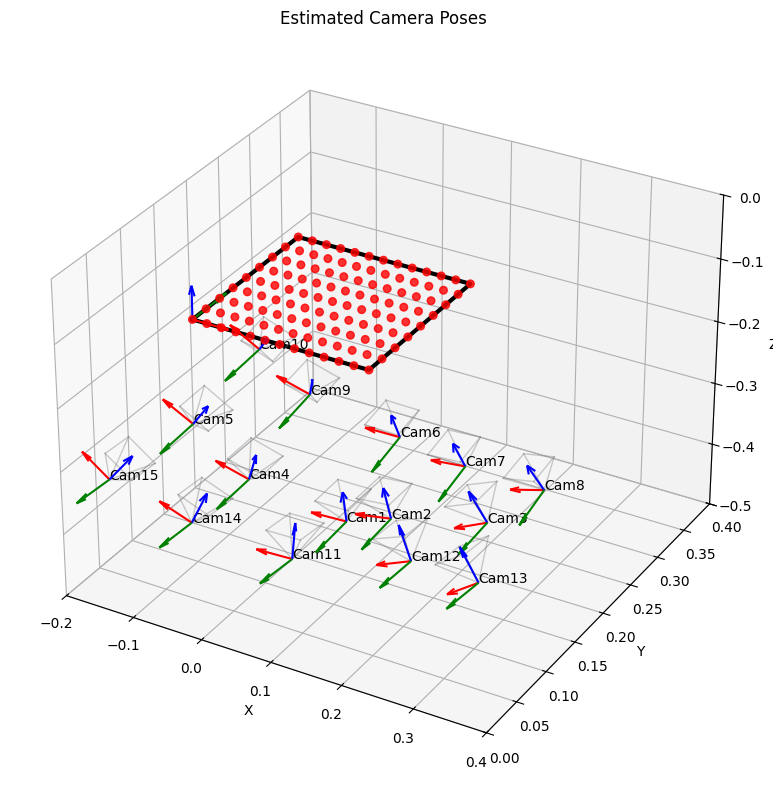

In [9]:
from mpl_toolkits.mplot3d import Axes3D

def plot_camera_frustum(ax, R, camera_center, scale):
    """
    Visualize the camera frustum (field of view).
    """
    l, w, h = scale * 1.5, scale * 0.8, scale * 0.6
    
    # Frustum corner points in camera coordinates
    frustum_points_local = np.array([
        [0, 0, 0],  # Camera center
        [-w, -h, l],
        [ w, -h, l],
        [ w,  h, l],
        [-w,  h, l]
    ])
    
    # Transform to world coordinates
    frustum_points_world = []
    for point in frustum_points_local:
        world_point = R @ point + camera_center
        frustum_points_world.append(world_point)
    
    frustum_points_world = np.array(frustum_points_world)
    
    # Draw lines from camera center to each corner and between corners
    for i in range(1, 5):
        ax.plot(
            [frustum_points_world[0, 0], frustum_points_world[i, 0]],
            [frustum_points_world[0, 1], frustum_points_world[i, 1]],
            [frustum_points_world[0, 2], frustum_points_world[i, 2]], 
            color='gray', alpha=0.4, linewidth=1
        )
        next_i = i + 1 if i < 4 else 1
        ax.plot(
            [frustum_points_world[i, 0], frustum_points_world[next_i, 0]],
            [frustum_points_world[i, 1], frustum_points_world[next_i, 1]],
            [frustum_points_world[i, 2], frustum_points_world[next_i, 2]], 
             color='gray', alpha=0.4, linewidth=1
        )
    
def plot_camera_poses(extrinsics):
    """
    Visualize camera extrinsics and ChArUco board in 3D space.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Draw ChArUco board corners
    squares_x, squares_y = 13, 9
    square_length = 0.02

    x_coords, y_coords = np.meshgrid(
        np.arange(squares_x) * square_length,
        np.arange(squares_y) * square_length
    )
    z_coords = np.zeros_like(x_coords.flatten())
    
    ax.scatter(x_coords.flatten(), y_coords.flatten(), z_coords, c='red', s=30, alpha=0.8)
    
    # Draw board boundary
    max_x = (squares_x - 1) * square_length
    max_y = (squares_y - 1) * square_length
    boundary_x = [0, max_x, max_x, 0, 0]
    boundary_y = [0, 0, max_y, max_y, 0]
    boundary_z = [0, 0, 0, 0, 0]
    ax.plot(boundary_x, boundary_y, boundary_z, 'k-', linewidth=3)

    # Draw world coordinate axes
    ax.quiver(0, 0, 0, 0.1, 0, 0, color='r', length=0.5)
    ax.quiver(0, 0, 0, 0, 0.1, 0, color='g', length=0.5)
    ax.quiver(0, 0, 0, 0, 0, 0.1, color='b', length=0.5)

    for idx, (R, t) in enumerate(extrinsics):
        # Camera center in world coordinates
        C = -R.T @ t

        # Draw camera axes
        cam_axis = R.T
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 0], cam_axis[1, 0], cam_axis[2, 0], color='r', length=0.05)
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 1], cam_axis[1, 1], cam_axis[2, 1], color='g', length=0.05)
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 2], cam_axis[1, 2], cam_axis[2, 2], color='b', length=0.05)

        ax.text(C[0], C[1], C[2], f"Cam{idx+1}", color='black')

        plot_camera_frustum(ax, R, C, scale=0.03)

    # Set axis limits (centered on chessboard)
    ax.set_xlim(-0.2, 0.4)
    ax.set_ylim(0.0, 0.4)
    ax.set_zlim(-0.5, 0.0)

    ax.set_title("Estimated Camera Poses")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=30, azim=-60)
    plt.tight_layout()
    plt.show()

plot_camera_poses(extrinsics)